<a href="https://colab.research.google.com/github/kbandesz/NWC_W1/blob/main/NWC_W1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Prerequisites
You will need to install the following libraries:

In [ ]:
!pip install pandas numpy matplotlib statsmodels pmdarima openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 8.9 MB/s eta 0:00:00


**Important Note on X-13:** Notebook 2 uses **X-13ARIMA-SEATS** for seasonal adjustment. To run this successfully, you must have the X-13 binary executable installed on your system.

1. Download it from the [US Census Bureau](https://www.census.gov/data/software/x13as.html).

2. Unzip it to a known location (e.g., C:/x13as/x13as.exe).

3. Update the X13_BINARY_PATH variable in **Notebook 2**.

## Data Import & Baseline Analysis
**Replicates:** `0_part_1_import_india.prg`, `1_data_cleaning.prg` (Part 1)

Importing Monthly Data...
Importing Quarterly Data...
Data Loaded Successfully.
Monthly Range: 1999-01-01 00:00:00 to 2023-05-01 00:00:00
Quarterly Range: 1999-03-31 00:00:00 to 2023-03-31 00:00:00


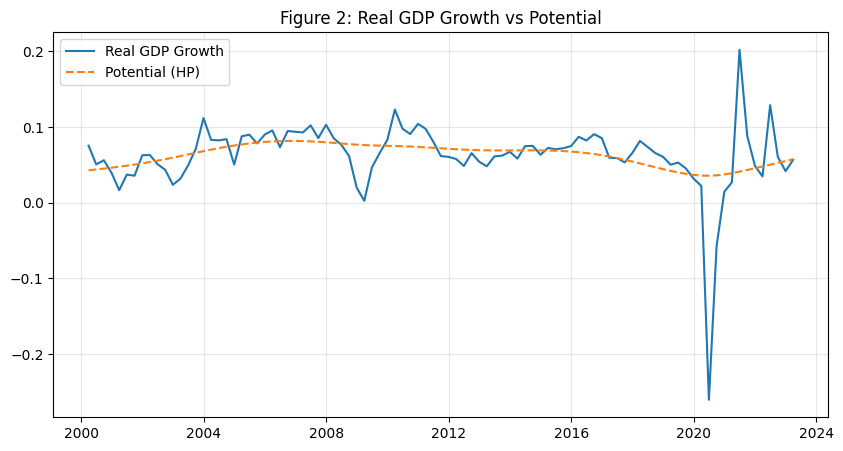

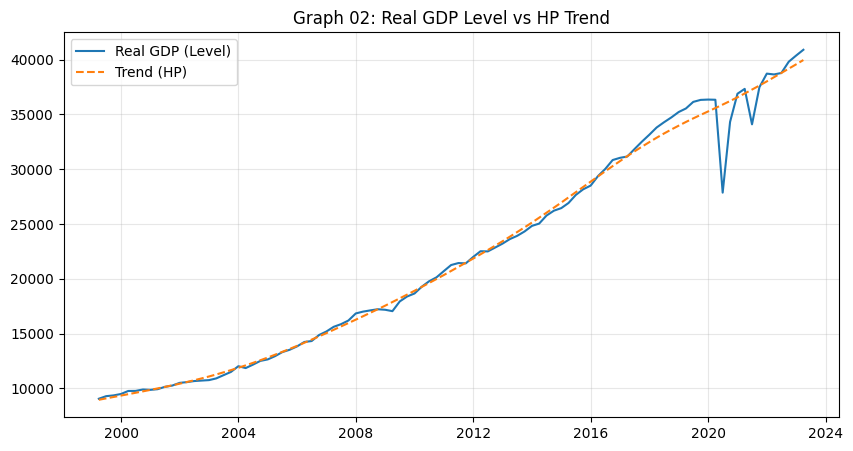

Notebook 1 Complete.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.filters.hp_filter import hpfilter
import re

# ==========================================
# 1. FIXED COLUMN IMPORT FUNCTION
# ==========================================
def import_india_data_fixed(file_path, sheet_name, freq):
    """
    Imports data from India.xlsx.
    - Handles headers read as floats (e.g. 199901.0 -> 199901)
    - Metadata in Cols B-O (Ignored)
    - Data starts at Col P (Index 15)
    """
    try:
        # Read header=0 to capture dates
        df = pd.read_excel(file_path, sheet_name=sheet_name, header=0)
    except FileNotFoundError:
        print(f"Error: {file_path} not found.")
        return pd.DataFrame()

    # 1. Isolate Data
    # Series IDs are in Column A (Index 0)
    series_ids = df.iloc[:, 0]

    # Data starts at Column P (Index 15)
    data_part = df.iloc[:, 15:]
    data_part.index = series_ids

    # 2. Transpose (Rows -> Columns)
    df_transposed = data_part.T

    # 3. Drop rows with empty/NaN headers
    df_transposed = df_transposed[df_transposed.index.notna()]

    # 4. Clean Date Index
    clean_dates = []
    for val in df_transposed.index:
        try:
            # Robust conversion: 199901.0 (float) -> 199901 (int) -> "199901" (str)
            clean_str = str(int(float(val)))
        except (ValueError, TypeError):
            # Fallback for pure text garbage (regex clean)
            clean_str = re.sub(r'[^\d]', '', str(val))
        clean_dates.append(clean_str)

    # 5. Parse Dates
    if freq == 'M':
        # Format: YYYYMM (199901)
        valid_indices = []
        valid_dates = []

        for i, date_str in enumerate(clean_dates):
            try:
                # Must be 6 digits
                if len(date_str) == 6:
                    dt = pd.to_datetime(date_str, format='%Y%m')
                    valid_dates.append(dt)
                    valid_indices.append(df_transposed.index[i])
            except ValueError:
                continue

        # Rebuild DataFrame with valid dates only
        df_final = df_transposed.loc[valid_indices].copy()
        df_final.index = pd.DatetimeIndex(valid_dates) + pd.offsets.MonthBegin(0)

    elif freq == 'Q':
        # Format: YYYYQ (19991)
        valid_indices = []
        valid_dates = []

        for i, date_str in enumerate(clean_dates):
            try:
                # Must be 5 digits (YYYYQ)
                if len(date_str) == 5:
                    year = int(date_str[:4])
                    quarter = int(date_str[4:])

                    # Sanity check
                    if 1 <= quarter <= 4:
                        # Quarter End Date
                        dt = pd.Timestamp(year=year, month=quarter*3, day=1) + pd.offsets.MonthEnd(1)
                        valid_dates.append(dt)
                        valid_indices.append(df_transposed.index[i])
            except (ValueError, TypeError):
                continue

        df_final = df_transposed.loc[valid_indices].copy()
        df_final.index = pd.DatetimeIndex(valid_dates)

    # 6. Final Cleanup
    df_final.index.name = 'Date'
    df_final = df_final.apply(pd.to_numeric, errors='coerce')

    return df_final

# ==========================================
# 2. LOAD DATA
# ==========================================
file_path = 'India.xlsx'

print("Importing Monthly Data...")
df_m = import_india_data_fixed(file_path, 'Monthly', 'M')

print("Importing Quarterly Data...")
df_q = import_india_data_fixed(file_path, 'Quarterly', 'Q')

# Rename 'rgdp_sa' to 'rgdp'
target_col = [c for c in df_q.columns if 'rgdp_sa' in c.lower()]
if target_col:
    df_q.rename(columns={target_col[0]: 'rgdp'}, inplace=True)

print(f"Data Loaded Successfully.")
if not df_m.empty:
    print(f"Monthly Range: {df_m.index.min()} to {df_m.index.max()}")
if not df_q.empty:
    print(f"Quarterly Range: {df_q.index.min()} to {df_q.index.max()}")

# ==========================================
# 3. TRANSFORMATIONS & HP FILTER
# ==========================================
if 'rgdp' in df_q.columns:
    df_q['rgdp_log'] = np.log(df_q['rgdp'])
    df_q['rgdp_growth'] = df_q['rgdp_log'].diff(4)

    valid_growth = df_q['rgdp_growth'].dropna()
    valid_level = df_q['rgdp'].dropna()

    if not valid_growth.empty:
        cycle_g, trend_g = hpfilter(valid_growth, lamb=1600)
        df_q.loc[trend_g.index, 'hptrend01'] = trend_g

        cycle_l, trend_l = hpfilter(valid_level, lamb=1600)
        df_q.loc[trend_l.index, 'hptrend02'] = trend_l

        # Figure 2
        plt.figure(figsize=(10, 5))
        plt.plot(df_q.index, df_q['rgdp_growth'], label='Real GDP Growth')
        plt.plot(df_q.index, df_q['hptrend01'], label='Potential (HP)', linestyle='--')
        plt.title('Figure 2: Real GDP Growth vs Potential')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

        # -------------------------------------------------------
        # REPLICATION: Graph 02 (Levels)
        # Corresponds to: freeze(graph02_rgdp) grp02_rgdp.line
        # -------------------------------------------------------
        plt.figure(figsize=(10, 5))
        plt.plot(df_q.index, df_q['rgdp'], label='Real GDP (Level)')
        plt.plot(df_q.index, df_q['hptrend02'], label='Trend (HP)', linestyle='--')
        plt.title('Graph 02: Real GDP Level vs HP Trend')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
else:
    print("Warning: 'rgdp' not found in Quarterly data.")

# ==========================================
# 4. CRISIS DUMMY
# ==========================================
if not df_q.empty:
    df_q['CRISIS'] = 0
    # Dates: 2009Q1, 2016Q4, 2020Q2, 2021Q2 (Quarter Ends)
    crisis_dates = [
        pd.Timestamp('2009-03-31'),
        pd.Timestamp('2016-12-31'),
        pd.Timestamp('2020-06-30'),
        pd.Timestamp('2021-06-30')
    ]

    for date in crisis_dates:
        mask = (df_q.index.year == date.year) & (df_q.index.quarter == date.quarter)
        df_q.loc[mask, 'CRISIS'] = 1



## Seasonal Adjustment & Bridge Model
**Replicates:** `1_data_cleaning.prg` (Part 3), `2_bridge_basic.prg`

This notebook performs seasonal adjustment (defaulting to X-13), forecasts monthly indicators using Auto-ARIMA, aggregates them to quarterly frequency, and runs the Bridge regression.

X-13 Binary not found. Using STL.
Extending pmi_new by 1 months...
Extending consu_motor_sa by 1 months...
                            OLS Regression Results                            
Dep. Variable:              dlog_rgdp   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                     79.77
Date:                Tue, 16 Dec 2025   Prob (F-statistic):           1.03e-35
Time:                        19:43:30   Log-Likelihood:                 264.55
No. Observations:                  92   AIC:                            -511.1
Df Residuals:                      83   BIC:                            -488.4
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------

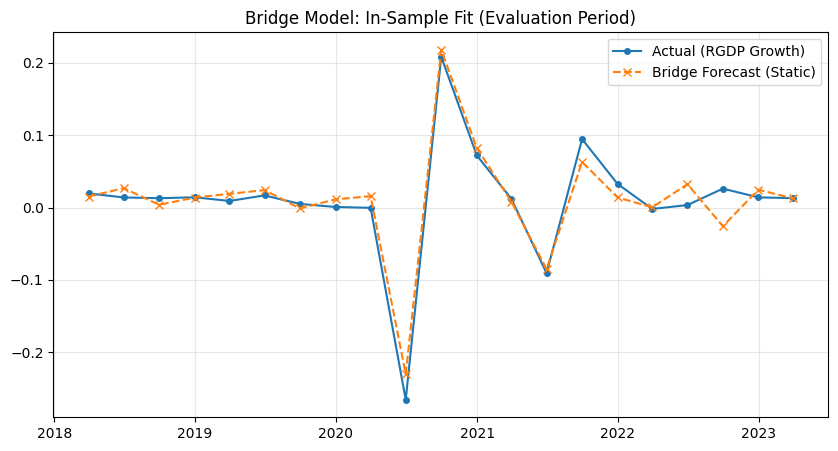


Bridge Forecast Table (Last 4 Quarters):
              Actual    Fitted  Residual
Date                                    
2022-06-30  0.003436  0.032247 -0.028811
2022-09-30  0.026158 -0.025726  0.051884
2022-12-31  0.014056  0.024714 -0.010658
2023-03-31  0.012972  0.012544  0.000428


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pmdarima as pm
import statsmodels.formula.api as smf
from statsmodels.tsa.x13 import x13_arima_analysis
from statsmodels.tsa.seasonal import STL
import os

# ==========================================
# CONFIGURATION
# ==========================================
# Update this to your X-13 path
X13_BINARY_PATH = r"C:\x13as\x13as.exe"

# ==========================================
# 1. SEASONAL ADJUSTMENT
# ==========================================
if not df_m.empty:
    consu_cols = [c for c in df_m.columns if 'consu_motor' in c.lower()]

    if consu_cols:
        target_col = consu_cols[0]
        series_to_sa = df_m[target_col].dropna().asfreq('MS')

        if os.path.exists(X13_BINARY_PATH):
            print("Running X-13...")
            try:
                res = x13_arima_analysis(
                    series_to_sa,
                    x12path=X13_BINARY_PATH,
                    prefer_x13=True,
                    outlier=True  # Enable outlier detection for whole series (not exclusively COVID)
                )
                df_m['consu_motor_sa'] = res.seasadj
                print("X-13 Success.")
            except Exception as e:
                print(f"X-13 Failed: {e}. Using STL.")
                res = STL(series_to_sa, seasonal=13).fit()
                df_m['consu_motor_sa'] = res.trend + res.resid
        else:
            print("X-13 Binary not found. Using STL.")
            res = STL(series_to_sa, seasonal=13).fit()
            df_m['consu_motor_sa'] = res.trend + res.resid
    else:
        print("Warning: consu_motor not found.")

# ==========================================
# 2. BRIDGE EXTENSION
# ==========================================
target_end = pd.Timestamp('2023-06-30')

def extend_series(series, end_date):
    last_date = series.dropna().index[-1]
    months = (end_date.year - last_date.year) * 12 + (end_date.month - last_date.month)

    if months <= 0: return series.dropna()

    print(f"Extending {series.name} by {months} months...")
    model = pm.auto_arima(series.dropna(), seasonal=False, suppress_warnings=True)
    fc = model.predict(n_periods=months)

    # Create extension index
    idx = pd.date_range(start=last_date + pd.offsets.MonthEnd(1), periods=months, freq='ME')
    return pd.concat([series.dropna(), pd.Series(fc, index=idx)])

# Create Extended Variables
if 'pmi_new' in df_m.columns:
    df_m['pmi_ext'] = extend_series(df_m['pmi_new'], target_end)

if 'consu_motor_sa' in df_m.columns:
    df_m['consu_ext'] = extend_series(df_m['consu_motor_sa'], target_end)

# ==========================================
# 3. QUARTERLY AGGREGATION & ALIGNMENT
# ==========================================
if 'pmi_ext' in df_m.columns and 'consu_ext' in df_m.columns:
    # 1. Aggregate High Freq to Quarterly
    q_pmi = df_m['pmi_ext'].resample('QE').mean()
    q_consu = df_m['consu_ext'].resample('QE').sum()

    # 2. ROOT CAUSE FIX: Align df_q to the extended timeline
    # We create a new index that covers both historical data AND the forecast period
    full_idx = df_q.index.union(q_pmi.index).sort_values()
    df_est = df_q.reindex(full_idx)

    # 3. Add Aggregated Variables
    df_est['pmi_new'] = q_pmi
    df_est['consu_motor'] = q_consu

    # 4. Recalculate Features on the EXTENDED DataFrame
    # This ensures lags for 2023Q2 are pulled correctly from 2023Q1 data
    df_est['dlog_rgdp'] = np.log(df_est['rgdp']).diff()
    df_est['dlog_consu'] = np.log(df_est['consu_motor']).diff()
    df_est['d_pmi'] = df_est['pmi_new'].diff()

    for i in range(1, 4):
        df_est[f'dlog_rgdp_{i}'] = df_est['dlog_rgdp'].shift(i)

    # External Vars
    us_col = [c for c in df_est.columns if 'rgdp_us' in c.lower()]
    cn_col = [c for c in df_est.columns if 'rgdp_cn' in c.lower()]

    # Using 'fillna(method='ffill')' is risky for GDP, but shift(1) is safe if previous row exists
    if us_col: df_est['dlog_us_1'] = np.log(df_est[us_col[0]]).diff().shift(1)
    else: df_est['dlog_us_1'] = 0

    if cn_col: df_est['dlog_cn_1'] = np.log(df_est[cn_col[0]]).diff().shift(1)
    else: df_est['dlog_cn_1'] = 0

    # 5. Fix CRISIS Dummy for new rows
    # The reindex created NaNs for 2023Q2. We must explicitly fill them with 0.
    df_est['CRISIS'] = df_est['CRISIS'].fillna(0)

    # ==========================================
    # 4. BRIDGE ESTIMATION
    # ==========================================
    mask = (df_est.index >= '2000-03-31') & (df_est.index <= '2023-03-31')
    formula = "dlog_rgdp ~ dlog_rgdp_1 + dlog_rgdp_2 + dlog_rgdp_3 + dlog_consu + d_pmi + dlog_us_1 + dlog_cn_1 + CRISIS"

    model_bridge = smf.ols(formula, data=df_est.loc[mask]).fit()
    print(model_bridge.summary())

    # Nowcast
    target_row = df_est.loc['2023-06-30':'2023-06-30']

    # Check for remaining NaNs (Debug)
    if target_row.isnull().any().any():
        print("\n⚠️ Warning: Missing data in forecast row:")
        print(target_row.loc[:, target_row.isna().any()])

    pred = model_bridge.predict(target_row)
    print(f"\nBridge Nowcast 2023Q2 (QoQ): {pred.values[0]:.4f}")

    # -------------------------------------------------------
    # REPLICATION: bridge_static (Actual vs Fitted)
    # Corresponds to: freeze(bridge_static) eq01_f_bridge.fit(...)
    # -------------------------------------------------------
    # Define Evaluation Sample (2018Q1 to 2023Q1)
    eval_mask = (df_est.index >= '2018-03-31') & (df_est.index <= '2023-03-31')
    eval_data = df_est.loc[eval_mask]

    # Calculate Fitted Values
    bridge_fitted = model_bridge.predict(eval_data)

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(eval_data.index, eval_data['dlog_rgdp'], label='Actual (RGDP Growth)', marker='o', markersize=4)
    plt.plot(eval_data.index, bridge_fitted, label='Bridge Forecast (Static)', linestyle='--', marker='x')
    plt.title('Bridge Model: In-Sample Fit (Evaluation Period)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # Table Display (Tail)
    print("\nBridge Forecast Table (Last 4 Quarters):")
    compare_bridge = pd.DataFrame({'Actual': eval_data['dlog_rgdp'], 'Fitted': bridge_fitted})
    compare_bridge['Residual'] = compare_bridge['Actual'] - compare_bridge['Fitted']
    print(compare_bridge.tail(4))



## Notebook 3: MIDAS (Almon & U-MIDAS)
**Replicates:** `3_midas_basic.prg`

This notebook implements U-MIDAS (by manually creating skip-sampled variables) and Restricted MIDAS (using a custom Almon class).

Selecting optimal MIDAS lag (AIC)...
Best Lag Selected: 3 (AIC: -504.4082)
                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     55.65
Date:                Tue, 16 Dec 2025   Prob (F-statistic):           1.86e-33
Time:                        19:52:11   Log-Likelihood:                 267.20
No. Observations:                  89   AIC:                            -504.4
Df Residuals:                      74   BIC:                            -467.1
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------

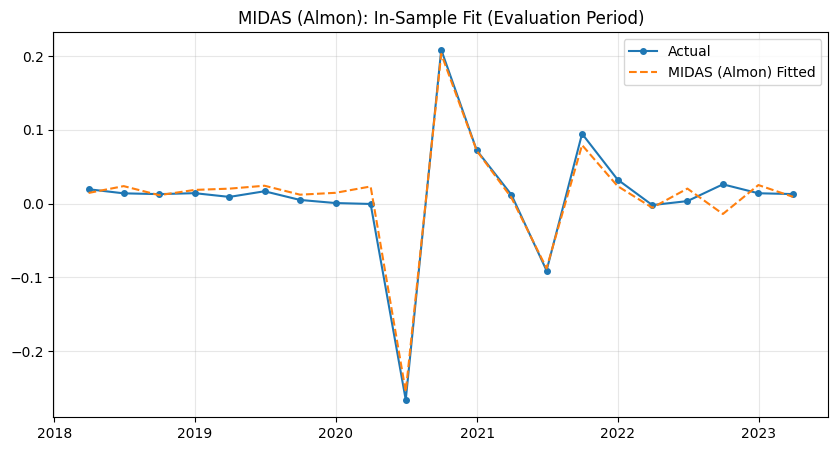


Estimating U-MIDAS...
                            OLS Regression Results                            
Dep. Variable:              dlog_rgdp   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.886
Method:                 Least Squares   F-statistic:                     58.03
Date:                Tue, 16 Dec 2025   Prob (F-statistic):           3.14e-33
Time:                        19:52:11   Log-Likelihood:                 261.60
No. Observations:                  89   AIC:                            -497.2
Df Residuals:                      76   BIC:                            -464.8
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0185     

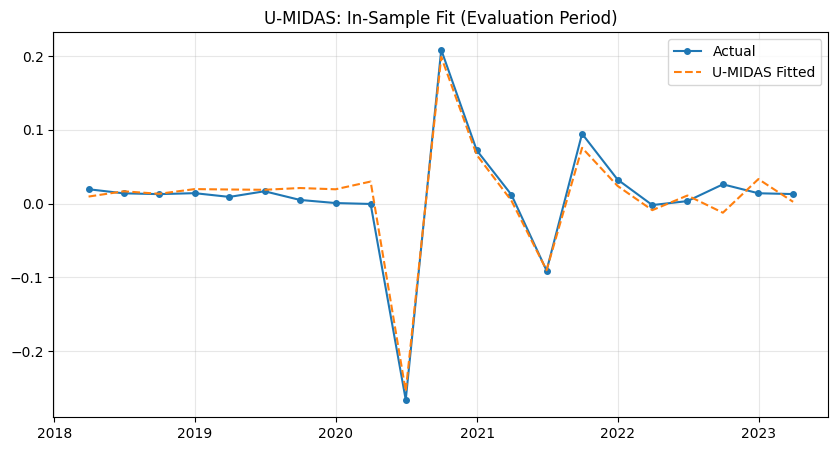

Notebook 3 Complete.


In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

# ==========================================
# 1. ALMON MIDAS CLASS
# ==========================================
class AlmonMidas:
    def __init__(self, degree=3, max_lag=12):
        self.degree = degree
        self.max_lag = max_lag
        self.model = None

    def _almon_transform(self, series):
        X_lags = []
        for lag in range(self.max_lag + 1):
            # Shift monthly series and resample to end-of-quarter
            lagged = series.shift(lag).resample('QE').last()
            X_lags.append(lagged)
        X_matrix = pd.concat(X_lags, axis=1)

        # Almon Polynomial Transformation
        Z_matrix = pd.DataFrame(index=X_matrix.index)
        for j in range(self.degree + 1):
            weights = np.array([k**j for k in range(self.max_lag + 1)])
            Z_matrix[f'poly_{j}'] = X_matrix.dot(weights)
        return Z_matrix

    def fit(self, y, x_high_freqs, x_low_freqs):
        # Prepare Design Matrix
        Z_combined = pd.DataFrame(index=y.index)

        for name, series in x_high_freqs.items():
            Z = self._almon_transform(series)
            Z.columns = [f'{name}_Z{i}' for i in range(len(Z.columns))]
            Z_combined = Z_combined.join(Z, how='left')

        Z_combined = Z_combined.join(x_low_freqs, how='left')
        Z_combined = sm.add_constant(Z_combined)

        # Align and Fit
        data = Z_combined.join(y.rename('Y'), how='inner').dropna()
        self.model = sm.OLS(data['Y'], data.drop(columns=['Y'])).fit()
        return self.model.summary()

    def predict(self, x_high_freqs, x_low_freqs):
        Z_combined = pd.DataFrame()
        for name, series in x_high_freqs.items():
            Z = self._almon_transform(series)
            Z.columns = [f'{name}_Z{i}' for i in range(len(Z.columns))]
            if Z_combined.empty: Z_combined = Z
            else: Z_combined = Z_combined.join(Z, how='outer')

        Z_combined = Z_combined.join(x_low_freqs, how='left')
        Z_combined = sm.add_constant(Z_combined)

        # Handle potential NaNs
        Z_combined = Z_combined.fillna(0)

        return self.model.predict(Z_combined)

# ==========================================
# 2. RUN MODELS
# ==========================================
# Ensure df_m and df_est exist from previous notebooks
if 'pmi_ext' in df_m.columns and not df_est.empty:

    # PREPARE REGRESSORS
    hf_consu = np.log(df_m['consu_ext']).diff()
    hf_pmi = df_m['pmi_ext'].diff()

    lf_cols = ['dlog_rgdp_1', 'dlog_rgdp_2', 'dlog_rgdp_3', 'dlog_us_1', 'dlog_cn_1', 'CRISIS']
    df_lf = df_est[lf_cols].copy()
    target = df_est['dlog_rgdp']

    # ---------------------------
    # A. RESTRICTED MIDAS (ALMON)
    # ---------------------------
    # REPLICATING EVIEWS 'LAG=AUTO'
    # We test lags 3 through 12 and select the one with the lowest AIC.

    mask_est = (target.index >= '2001-03-31') & (target.index <= '2023-03-31')

    best_aic = float('inf')
    best_lag = 12
    midas_almon = None  # This will hold the winning instance

    print("Selecting optimal MIDAS lag (AIC)...")

    for lag in range(3, 13):
        # 1. Instantiate model with current test lag
        current_model = AlmonMidas(degree=3, max_lag=lag)

        # 2. Fit model
        # We suppress printing the summary inside the loop
        current_model.fit(
            y=target[mask_est],
            x_high_freqs={'CONSU': hf_consu, 'PMI': hf_pmi},
            x_low_freqs=df_lf[mask_est]
        )

        # 3. Check AIC
        # The class stores the statsmodels result in .model
        current_aic = current_model.model.aic

        if current_aic < best_aic:
            best_aic = current_aic
            best_lag = lag
            midas_almon = current_model

    print(f"Best Lag Selected: {best_lag} (AIC: {best_aic:.4f})")
    print(midas_almon.model.summary())

    almon_pred = midas_almon.predict({'CONSU': hf_consu, 'PMI': hf_pmi}, df_lf)

    if '2023-06-30' in almon_pred.index:
        val_almon = almon_pred.loc['2023-06-30']
        print(f"\nAlmon MIDAS Nowcast 2023Q2: {val_almon:.4f}")
    else:
        print("Warning: 2023Q2 not found in prediction index.")

    # -------------------------------------------------------
    # REPLICATION: midas_static (Actual vs Fitted)
    # Corresponds to: freeze(midas_static) eq02_f_midas.fit(...)
    # -------------------------------------------------------
    # Get fitted values for the estimation/evaluation period
    midas_fitted = midas_almon.predict({'CONSU': hf_consu, 'PMI': hf_pmi}, df_lf)

    # Filter to Evaluation Sample (2018Q1 - 2023Q1)
    # Ensure indices align
    eval_idx = df_lf.index[(df_lf.index >= '2018-03-31') & (df_lf.index <= '2023-03-31')]
    midas_fitted_eval = midas_fitted.loc[midas_fitted.index.isin(eval_idx)]
    actual_eval = target.loc[target.index.isin(eval_idx)]

    plt.figure(figsize=(10, 5))
    plt.plot(actual_eval.index, actual_eval, label='Actual', marker='o', markersize=4)
    plt.plot(midas_fitted_eval.index, midas_fitted_eval, label='MIDAS (Almon) Fitted', linestyle='--')
    plt.title('MIDAS (Almon): In-Sample Fit (Evaluation Period)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # ---------------------------
    # B. U-MIDAS (UNRESTRICTED)
    # ---------------------------
    def create_skip_sampled(series, prefix):
        # 1. Group by Quarter
        # Using period index allows safe alignment even if months are missing
        groups = series.groupby(series.index.to_period('Q'))

        m1 = groups.nth(0)
        m2 = groups.nth(1)
        m3 = groups.nth(2)

        # 2. Align Indices to Period('Q')
        m1.index = m1.index.to_period('Q')
        m2.index = m2.index.to_period('Q')
        m3.index = m3.index.to_period('Q')

        m1.name = f'{prefix}_m1'
        m2.name = f'{prefix}_m2'
        m3.name = f'{prefix}_m3'

        # 3. Concatenate (Automatic Alignment)
        # This handles length mismatches by filling missing months with NaN
        df_skip = pd.concat([m1, m2, m3], axis=1)

        # 4. Convert Index back to Timestamp (Quarter End)
        # Normalize ensures time is 00:00:00 to match df_est
        df_skip.index = df_skip.index.to_timestamp(how='end').normalize()

        return df_skip

    # Create variables
    skip_consu = create_skip_sampled(hf_consu, 'consu')
    skip_pmi = create_skip_sampled(hf_pmi, 'pmi')

    # Merge Skip-Sampled vars with Low Freq data
    df_umidas = df_est.copy()
    # Join on index (Quarter End)
    df_umidas = df_umidas.join([skip_consu, skip_pmi], how='left')

    formula_umidas = "dlog_rgdp ~ dlog_rgdp_1 + dlog_rgdp_2 + dlog_rgdp_3 + dlog_us_1 + dlog_cn_1 + CRISIS + consu_m1 + consu_m2 + consu_m3 + pmi_m1 + pmi_m2 + pmi_m3"

    # Fit U-MIDAS
    # Use dropna() to handle the potentially shorter samples from skip-sampling gaps
    est_data = df_umidas.loc[mask_est].dropna()

    print("\nEstimating U-MIDAS...")
    model_umidas = smf.ols(formula_umidas, data=est_data).fit()
    print(model_umidas.summary())

    # Forecast U-MIDAS
    target_row = df_umidas.loc['2023-06-30':]

    # Fill any remaining NaNs in the target row (e.g. if lags are missing)
    if not target_row.empty:
        target_row = target_row.fillna(0)
        pred_umidas = model_umidas.predict(target_row)
        print(f"\nU-MIDAS Nowcast 2023Q2: {pred_umidas.values[0]:.4f}")
    else:
        print("U-MIDAS Target row empty.")

    # -------------------------------------------------------
    # REPLICATION: umidas_static (Actual vs Fitted)
    # Corresponds to: freeze(umidas_static) eq03_f_umidas.fit(...)
    # -------------------------------------------------------
    # Predict over Evaluation Sample
    eval_mask_u = (df_umidas.index >= '2018-03-31') & (df_umidas.index <= '2023-03-31')
    eval_data_u = df_umidas.loc[eval_mask_u].dropna()

    umidas_fitted = model_umidas.predict(eval_data_u)

    plt.figure(figsize=(10, 5))
    plt.plot(eval_data_u.index, eval_data_u['dlog_rgdp'], label='Actual', marker='o', markersize=4)
    plt.plot(eval_data_u.index, umidas_fitted, label='U-MIDAS Fitted', linestyle='--')
    plt.title('U-MIDAS: In-Sample Fit (Evaluation Period)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

print("Notebook 3 Complete.")